<table>
<tr>
    <td width=25%>
        <img src=" 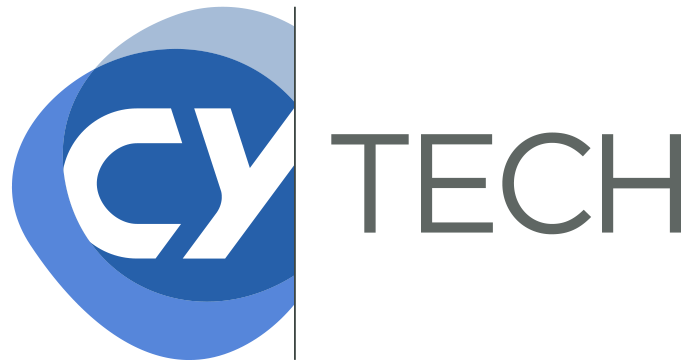" />
    </td>
    <td>
        <center>
            <h1>Deep Learning et Applications</h1>
        </center>
    </td>
    <td width=15%>
        Paul Gay
    </td>
</tr>
</table>

<br/>
<div id="top"></div>
<center>
    <a style="font-size: 20pt; font-weight: bold">Lab. 1 - Transformeurs. Sentiment classification</a>
</center>
<br/>

---
Ce notebook vous propose d'effectuer de la classification de texte. Nous allons implémenter un modèle simple constitué d'un encodeur contenant un bloc d'auto attention avec 2 têtes. 


Ce notebook s'inspire d'un tutoriel de [tensorflow](https://www.tensorflow.org/tutorials/text/transformer) qui propose d'écrire un modèle de traduction. Vous pouvez consulter cette ressource pour construire un encodeur/décodeur.

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

Commençons par charger les données IMDB, (que nous connaissons bien maintenant)

In [11]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
word2idx = tf.keras.datasets.imdb.get_word_index(path="imdb_word_index.json")
idx2word = dict([(k,w) for (w,k) in word2idx.items() ])

25000 Training sequences
25000 Validation sequences


In [12]:
idx2word = dict([(k,w) for (w,k) in word2idx.items() ])

Affichons le texte d'une critique.

In [13]:
print(' '.join([idx2word[i] for i in x_train[1]  if i in idx2word ]))

the thought solid thought senator do making to is spot nomination assumed while he of jack in where picked as getting on was did hands fact characters to always life thrillers not as me can't in at are br of sure your way of little it strongly random to view of love it so principles of guy it used producer of where it of here icon film of outside to don't all unique some like of direction it if out her imagination below keep of queen he diverse to makes this stretch stefan of solid it thought begins br senator machinations budget worthwhile though ok brokedown awaiting for ever better were and diverse for budget look kicked any to of making it out and follows for effects show to show cast this family us scenes more it severe making senator to and finds tv tend to of emerged these thing wants but and an beckinsale cult as it is video do you david see scenery it in few those are of ship for with of wild to one is very work dark they don't do dvd with those them


### Positional encoding

EXERCICE 1 : Trouvez le code de la fonction de l'encodage positionnel de façon à obtenir la visualisation de la formule suivante

In [14]:
def get_angles(pos, i, d_model):
    # Votre code ici
    
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


Affichage du motif de l'encodage positionnel

(1, 2048, 512)


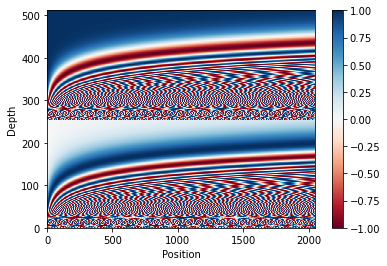

In [15]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Nous créons à présent une couche permettant de créer notre plongement lexical. Ce plongement est de type word2vec dans le sens ou il associe un vecteur à chaque mot sans tenir compte du contexte. 

Ce vecteur sera l'entrée de notre transformeur qui le raffinera en y intégrant le contexte. 

Ce vecteur d'entrée est constitué d'une couche Embedding de Keras qui sera apprise par le réseau, et d'un descripteur qui encode la position du mot dans la phrase en utilisant les fonctions décrites précédemment.

EXERCICE 2: Compléter la fonction forward de la couche d'embedding d'entrée

In [16]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = positional_encoding(maxlen, embed_dim) # layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.embed_dim = embed_dim

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = # calcul de l'embedding sémantique
        x *=  # normalisation des embeddings en fonction de leur dimension
        x += # ajout de l'embedding de position
        return x

Testons notre nouvelle couche sur un vecteur aléatoire et affichage de la dimension: 

In [27]:
embed_dim = 32
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
out = embedding_layer(x_train[0])
print(out.shape)

(1, 200, 32)


Cette fonction calcule les scores d'attention

In [28]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calcul des poids d'attention
  q, k, v doivent avoir la même dimension
  k, v doivent avoir la même avant dernière dimension, i.e.: seq_len_k = seq_len_v.
  
  Args:
    q: requête de taille == (..., seq_len_q, depth)
    k: clé de taille == (..., seq_len_k, depth)
    v: valeur de taille == (..., seq_len_v, depth_v)
    mask: Tenseur de réél pouvant être additionné aux valeurs de taille (..., seq_len_q, seq_len_k). Valeur par défaut est None.

  Returns:
    output, attention_weights
  """

  # multiplication entre la clé et la requête
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # normalisation par la taille de l'état interne du modèle
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # Ajout du masque
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # Softmax le long de la dernière dimension afin que la somme des poids égale 1. 
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  # Somme pondérée des valeurs par les poids d'attention
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Quelques tests additionels

In [29]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)


Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Couche d'auto attention pouvant comporter plusieurs têtes.

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    # projection du plongement afin de construire les vecteurs de clés, valeurs, et requêtes
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Test de notre nouvelle couche

In [31]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape


(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

Bloc transformeur qui ajoute les couches connectées aux couches d'attention

EXERCICE 3: Compléter la fonction qui effectue la passe forward (call) avec

Une couche d'auto attention (MultiHeadAttention)

Une couche de normalisation avec connection résiduelle sur la couche d'auto attention (il faut sommer l'entrée et la sortie de la couche d'auto attention)

Passage par un perceptron multi couches

Une couche de normalisation avec connection résiduelle par rapport au perceptron


In [32]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = keras.Sequential(
            [layers.Dense(dff, activation="relu"), layers.Dense(d_model),]
        )
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training):
    # Votre code ici
    return out2


Test de notre couche de l'encodeur

In [33]:
# test d'une couche de l'encodeur
sample_encoder_layer = EncoderLayer(32, 2, 32*4)
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 32)), False )
print('size of the decoder output', sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)

size of the decoder output (64, 43, 32)


Modèle final de notre encodeur, où nous ajoutons un pooling pour revenir à une taille fixe et un softmax pour prédire le nombre de classes

In [34]:
embed_dim =  32 # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = embed_dim*4   # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = EncoderLayer(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 32)           640000    
_________________________________________________________________
encoder_layer_5 (EncoderLaye (None, 200, 32)           12704     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 20)                660       
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0     

Entrainement du modèle

In [36]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
782/782 [==============================] - 32s 40ms/step - loss: 0.1039 - accuracy: 0.9654 - val_loss: 0.4260 - val_accuracy: 0.8537
Epoch 2/2
782/782 [==============================] - 30s 39ms/step - loss: 0.0500 - accuracy: 0.9844 - val_loss: 0.4896 - val_accuracy: 0.8456


Test